# Compulsory 2 - Erlend Risvik

## Loading and preprocessing data
Start by loading in the secret ID

In [1]:
import ast
import requests
import pandas as pd
from pyspark.sql import SparkSession
import os

SECRET_INFO = open("../NO_SYNC/weather_api", 'r').read().replace('\n', '')
SECRET_ID = ast.literal_eval(SECRET_INFO)["client_id"]

In CA1, we selected locality 12765.

Let's start by finding out the GPS coordinates of our locality

In [3]:
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

(spark.read.format("org.apache.spark.sql.cassandra")
 .options(table="fish_data_full", keyspace="compulsory")
 .load()
 .createOrReplaceTempView("fish_data_full"))

fish_data = spark.sql("select localityno, lon, lat, municipality, name from fish_data_full").toPandas()

In [4]:
# Select the GPS coordinates of locality 12765, and separate them by space
lat = round(fish_data.loc[fish_data['localityno'] == 12765, 'lat'].values[0], 3)
lon = round(fish_data.loc[fish_data['localityno'] == 12765, 'lon'].values[0], 3)
# Select the municipality and name of the same locality

municipality = fish_data.loc[fish_data['localityno'] == 12765, 'municipality'].values[0]
name = fish_data.loc[fish_data['localityno'] == 12765, 'name'].values[0]

# print lon, lat, municipality, name in f string nicely
print(f"Lon: {lon:.4f}\nLat: {lat:.4f}\nMunicipality: {municipality}\nPlace: {name}")

Lon: 9.9740
Lat: 62.0940
Municipality: Folldal
Place: Aasen Gård


In [5]:
endpoint = 'https://frost.met.no/sources/v0.jsonld'
parameters = {
"geometry" : f"nearest(POINT({lon} {lat}))",
"nearestmaxcount": 15,
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [6]:
# Go through each json object in the data list, and print the shortname, id and distance
for item in data:
    print(f"Shortname: {item['shortName']}\nID: {item['id']}\nDistance: {item['distance']}\n")
    

Shortname: Grimse 
ID: SN9050
Distance: 3.55522119643

Shortname: Folldal 
ID: SN9160
Distance: 3.95215517934

Shortname: Folldal (Li bru)
ID: SN8780
Distance: 9.44318857176

Shortname: FV29 Gravbekklia
ID: SN9250
Distance: 16.62512550816

Shortname: Atnsjøen
ID: SN8720
Distance: 24.25914849366

Shortname: Einunna
ID: SN8970
Distance: 24.47754731071

Shortname: Hjerkinn
ID: SN9310
Distance: 26.478453523970003

Shortname: E6 Hjerkinn
ID: SN9303
Distance: 27.607994447699998

Shortname: E6 Avsjøen
ID: SN16620
Distance: 27.655905071

Shortname: E6 Grønbakken
ID: SN63940
Distance: 28.53821021009

Shortname: Alvdal 
ID: SN8880
Distance: 34.00673936603

Shortname: Høvringen
ID: SN16271
Distance: 34.483657391369995

Shortname: RV3 Bergerønningen
ID: SN9400
Distance: 34.70172348205

Shortname: E6 Fokstugu
ID: SN16611
Distance: 35.83972754819

Shortname: Fokstugu
ID: SN16610
Distance: 35.84706832411



In [19]:
# SN16610 contains the information needed
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN16610',
    'elements': 'sum(precipitation_amount P1D), mean(air_temperature P1D), mean(wind_speed P1D), mean(relative_humidity P1D)',
    'referencetime': '2015-01-01/2015-12-31',
    'levels' : 'default',
    'timeoffsets': 'default'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(SECRET_ID,''))
# Extract JSON data
json = r.json()

In [20]:
# print lentgh of data
print(f"Length of data: {len(json['data'])}")


Length of data: 364


In [21]:
df = pd.DataFrame()
data = json['data']
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row], ignore_index=True)

df = df.reset_index(drop=True)

columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df2 = df[columns].copy()
df2['referenceTime'] = pd.to_datetime(df2['referenceTime']).dt.strftime('%Y-%m-%d')
df2

,sourceId,referenceTime,elementId,value,unit,timeOffset
0,SN16610:0,2015-01-01,sum(precipitation_amount P1D),0.1,mm,PT6H
1,SN16610:0,2015-01-01,mean(air_temperature P1D),0.9,degC,PT0H
2,SN16610:0,2015-01-01,mean(wind_speed P1D),5.7,m/s,PT0H
3,SN16610:0,2015-01-01,mean(relative_humidity P1D),76.0,percent,PT0H
4,SN16610:0,2015-01-02,sum(precipitation_amount P1D),2.2,mm,PT6H
...,...,...,...,...,...,...
1449,SN16610:0,2015-12-29,mean(relative_humidity P1D),83.0,percent,PT0H
1450,SN16610:0,2015-12-30,sum(precipitation_amount P1D),2.3,mm,PT6H
1451,SN16610:0,2015-12-30,mean(air_temperature P1D),-3.2,degC,PT0H
1452,SN16610:0,2015-12-30,mean(wind_speed P1D),16.1,m/s,PT0H


In [22]:
# convert from wide to long format
df3 = df2.pivot(index='referenceTime', columns='elementId', values='value').reset_index()
# give better column names
df3.columns = ['date', 'temperature', 'humidity', 'wind_speed', 'precipitation']
df3

,date,temperature,humidity,wind_speed,precipitation
0,2015-01-01,0.9,76.0,5.7,0.1
1,2015-01-02,-3.1,91.0,6.7,2.2
2,2015-01-03,-6.3,96.0,4.4,5.8
3,2015-01-04,-7.4,92.0,4.3,0.3
4,2015-01-05,-4.7,89.0,1.5,0.4
...,...,...,...,...,...
359,2015-12-26,-10.3,83.0,3.5,1.6
360,2015-12-27,-11.0,71.0,2.5,0.0
361,2015-12-28,-10.6,79.0,2.0,0.4
362,2015-12-29,-6.1,83.0,8.7,0.0


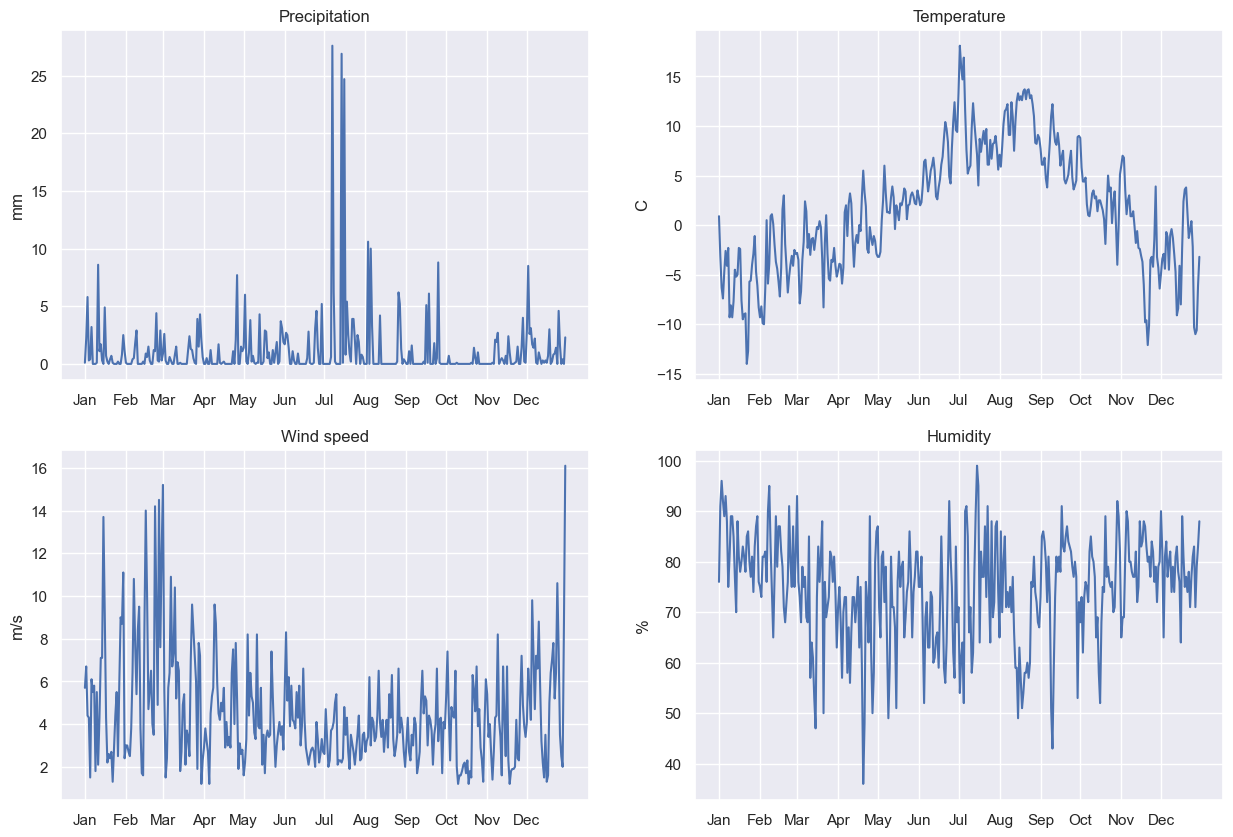

In [23]:
# plot the four variables
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ticks = ['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01']
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

sns.lineplot(ax=axes[0, 0], data=df3, x='date', y='precipitation')
axes[0, 0].set_title('Precipitation')
axes[0, 0].set_xticks(ticks)
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_ylabel('mm')

sns.lineplot(ax=axes[0, 1], data=df3, x='date', y='temperature')
axes[0, 1].set_title('Temperature')
axes[0, 1].set_xticks(ticks)
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_ylabel('C')

sns.lineplot(ax=axes[1, 0], data=df3, x='date', y='wind_speed')
axes[1, 0].set_title('Wind speed')
axes[1, 0].set_xticks(ticks)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].set_ylabel('m/s')

sns.lineplot(ax=axes[1, 1], data=df3, x='date', y='humidity')
axes[1, 1].set_title('Humidity')
axes[1, 1].set_xticks(ticks)
axes[1, 1].set_xticklabels(labels)
axes[1, 1].set_ylabel('%')

# hide the x label "date"
for ax in axes.flat:
    ax.set(xlabel='')

## Writing data to spark

In [31]:
from pyspark.sql import SparkSession
import os

# Set pyspark env
os.environ["PYSPARK_PYTHON"] = "python"

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()
session.set_keyspace('compulsory')

def convert_to_spark(df):
    """Function to convert pandas dataframe to spark dataframe

    Parameters:
    -----------
    df : pandas dataframe
        Dataframe to convert

    Returns:
    --------
    spark dataframe
    """
    return spark.createDataFrame(df)

def list_tables():
    """
    Function to list all tables in cassandra
    """
    query = "SELECT * FROM system_schema.tables WHERE keyspace_name='compulsory';"
    rows = session.execute(query)
    for i in rows:
        print(i)

In [25]:
list_tables()

Row(keyspace_name='compulsory', table_name='car_table', additional_write_policy='99p', bloom_filter_fp_chance=0.01, caching=OrderedMapSerializedKey([('keys', 'ALL'), ('rows_per_partition', 'NONE')]), cdc=None, comment='', compaction=OrderedMapSerializedKey([('class', 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy'), ('max_threshold', '32'), ('min_threshold', '4')]), compression=OrderedMapSerializedKey([('chunk_length_in_kb', '16'), ('class', 'org.apache.cassandra.io.compress.LZ4Compressor')]), crc_check_chance=1.0, dclocal_read_repair_chance=0.0, default_time_to_live=0, extensions=OrderedMapSerializedKey([]), flags=SortedSet(['compound']), gc_grace_seconds=864000, id=UUID('945dbc40-5954-11ee-8bb8-2f03669fdb2b'), max_index_interval=2048, memtable=None, memtable_flush_period_in_ms=0, min_index_interval=128, read_repair='BLOCKING', read_repair_chance=0.0, speculative_retry='99p')
Row(keyspace_name='compulsory', table_name='fish_data_full', additional_write_policy='99p', 

In [26]:
weather_spark = convert_to_spark(df3)

# create unique id for each row
from pyspark.sql.functions import monotonically_increasing_id
weather_spark = weather_spark.withColumn("id", monotonically_increasing_id())

In [33]:
weather_spark.show()

+----------+-----------+--------+----------+-------------+---+
|      date|temperature|humidity|wind_speed|precipitation| id|
+----------+-----------+--------+----------+-------------+---+
|2015-01-01|        0.9|    76.0|       5.7|          0.1|  0|
|2015-01-02|       -3.1|    91.0|       6.7|          2.2|  1|
|2015-01-03|       -6.3|    96.0|       4.4|          5.8|  2|
|2015-01-04|       -7.4|    92.0|       4.3|          0.3|  3|
|2015-01-05|       -4.7|    89.0|       1.5|          0.4|  4|
|2015-01-06|       -2.6|    93.0|       6.1|          3.2|  5|
|2015-01-07|       -4.1|    88.0|       5.5|          0.0|  6|
|2015-01-08|       -2.3|    75.0|       5.8|          0.0|  7|
|2015-01-09|       -9.3|    81.0|       1.8|          0.0|  8|
|2015-01-10|       -8.1|    89.0|       5.5|          0.1|  9|
|2015-01-11|       -9.3|    89.0|       2.1|          8.6| 10|
|2015-01-12|       -7.7|    85.0|       4.3|          1.1| 11|
|2015-01-13|       -4.5|    77.0|       7.1|          1

In [37]:
cassandra_types = {
    'date': 'text',
    'temperature': 'float',
    'humidity': 'float',
    'wind_speed': 'float',
    'precipitation': 'float'
}

table_name = "weather_data"
cql_create_table = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        id UUID PRIMARY KEY,
        {', '.join([f"{i} {cassandra_types[i]}" for i in weather_spark.columns if i != "id"])}
    );
""".replace("\n", " ")

session.execute(f"DROP TABLE IF EXISTS compulsory.{table_name};")
session.execute(cql_create_table)

In [29]:
cql_create_table

'     CREATE TABLE IF NOT EXISTS weather_data (         id UUID PRIMARY KEY,         date string, temperature float, humidity float, wind_speed float, precipitation float     ); '